In [1]:
for i in range(2):
    print(i)

0
1


In [116]:
import numpy as np
locations = np.array([20, 30, 58, 100])
locations[1:] -= 1
locations

array([20, 29, 57, 99])

In [9]:
import json
import yaml

data = {
    "accuracy": 1.0,
    "results": [1, "123", 3],
    "other info": {"info1": 1, "info2": "test", "info3": [1, 2, "5"]},
}
# print(json.dumps(data, sort_keys=True, indent=4, default=str))
print(yaml.dump(data, line_break="\n"))

accuracy: 1.0
other info:
  info1: 1
  info2: test
  info3:
  - 1
  - 2
  - '5'
results:
- 1
- '123'
- 3



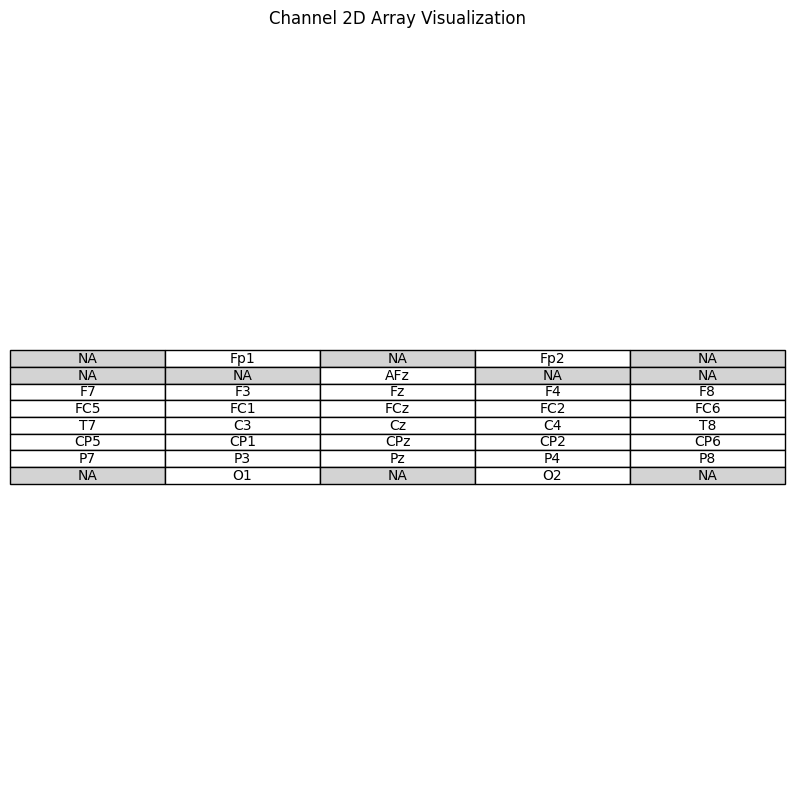

In [17]:
from shared.utilities import CHANNELS_2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))  # Set the figure size
ax.axis("tight")
ax.axis("off")
# Create a table and populate it with the data
table_data = []
# columns = ['Col1', 'Col2', 'Col3', 'Col4', 'Col5']  # You can name columns as per your requirement
for row in CHANNELS_2D:
    table_data.append(row)

table = ax.table(cellText=table_data, cellLoc="center", loc="center")

# Optionally: Style the table with color
colors = [
    ["lightgray" if cell == "NA" else "white" for cell in row] for row in CHANNELS_2D
]
for i, row in enumerate(colors):
    for j, color in enumerate(row):
        table[(i, j)].set_facecolor(color)

plt.title("Channel 2D Array Visualization")

plt.show()

In [8]:
import mne
from pathlib import Path

raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_303/3749368389.py:7: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_303/3749368389.py:11: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


<RawBrainVision | MD3-0021.eeg, 34 x 1381968 (2763.9 s), ~45 kB, data not loaded>

In [2]:
raw.info["sfreq"]

500.0

In [6]:
epochs = mne.read_epochs(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

Reading /mnt/c/GIT/hmp-ai/data/sat1/preprocessed/processed_0001_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
186 matching events found
No baseline correction applied
0 projection items activated


In [7]:
epochs.info["sfreq"]

100.0

In [1]:
%load_ext autoreload
%autoreload 2
from shared.generators import SAT1DataGenerator
import xarray as xr
from pathlib import Path
import numpy as np
from shared.generators import SequentialSAT1DataGenerator


2023-10-20 08:50:30.290117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 08:50:30.917633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
stage_data = xr.load_dataset(Path("data/sat1/stage_data.nc"))
split_stage_data = xr.load_dataset(Path("data/sat1/split_stage_data.nc"))

In [55]:
split_500 = xr.load_dataset(Path("data/sat1/split_stage_data_unprocessed_500hz.nc"))

In [113]:
for participant in stage_data.labels:
    for epoch in participant:
        if epoch[0] != "" and epoch[0] != "pre-attentive":
            print(epoch)

<xarray.DataArray 'labels' (samples: 199)>
array(['encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 

In [20]:
stage_data.sel(participant="0021", epochs=10).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'response', 'response', 'response', 'response',
       'response', 'response', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       ''], dtype=object)
Coordinates:
    epochs       int64 10
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'

In [29]:
labels = np.array(
    [
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "encoding",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "decision",
        "response",
        "response",
        "response",
        "response",
        "response",
        "response",
        "response",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)

In [34]:
print(np.insert(np.where(labels[:-1] != labels[1:]), 0, 0))

[  0  31 126 133]


In [48]:
label_data = stage_data.labels.to_numpy()
changes = np.where(label_data[:, :, :-1] != label_data[:, :, 1:])

In [111]:
test = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test[0:-1] = -1
test

array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  9])

In [50]:
changes

(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([  1,   1,   1, ..., 199, 199, 199]),
 array([ 19,  24,  61, ...,  41,  94, 101]))

In [9]:
test_1 = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3])
test_2 = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
print(np.where(test_1[:-1] != test_1[1:]))
print(test_1[3:6])
print(np.where(test_2[:-1] != test_2[1:]))

(array([2, 5]),)
[2 2 2]
(array([2, 4, 6]),)


In [53]:
split_stage_data.sel(labels="pre-attentive").data

<xarray.DataArray 'data' (participant: 25, epochs: 200, channels: 30,
                          samples: 154)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[ -1.78890336,  -0.51515442,  -3.88818479, ...,          nan,
                   nan,          nan],
         [ -1.41650987,  -1.790115  ,  -0.1448447 , ...,          nan,
                   nan,          nan],
         [ -1.64433873,  -1.18008411,  -3.29254103, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[-16.83752823, -12.14329338,  -4.24822187, ...,          nan,
                   nan,          nan],
         [-14.45732212, -11.87319565,  -9.3925457 , ...,          nan,
                   nan,          nan],
         [-16.47312737, -13.27057457,  -7.39222813, ...,          nan,
                   nan,          nan],
         ...,
         [  6.76353884,   6.67207766,   6.66653013, ...,          nan,
                   nan,          nan],
         [  5.1337595 ,   9.06184769,  11.17558861, ...,          nan,
                   nan,          nan],
         [  7.30947971,  15.75764847,  18.12044144, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * participant  (participant) object '0001' '0002' '0003' ... '0024' '0025'
    labels       <U13 'pre-attentive'
    stim         (participant, epochs) float64 nan 1.0 1.0 1.0 ... 2.0 nan 2.0
    resp         (participant, epochs) object '' 'resp_left' ... '' 'resp_left'
    rt           (participant, epochs) float64 nan 0.683 1.068 ... nan 1.02
    cue          (participant, epochs) object '' 'SP' 'AC' 'SP' ... 'SP' '' 'AC'
    movement     (participant, epochs) object '' 'stim_left' ... '' 'stim_right'
    trigger      (participant, epochs) object '' ... 'AC/stim_right/resp_left'

In [20]:
split_500

<xarray.Dataset>
Dimensions:      (channels: 30, samples: 770, epochs: 200, participant: 25,
                  labels: 5)
Coordinates:
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 763 764 765 766 767 768 769
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * participant  (participant) object '0001' '0002' '0003' ... '0024' '0025'
  * labels       (labels) object 'confirmation' 'decision' ... 'response'
    stim         (participant, epochs) float64 nan 1.0 1.0 1.0 ... 2.0 nan 2.0
    resp         (participant, epochs) object '' 'resp_left' ... '' 'resp_left'
    RT           (participant, epochs) float64 nan 0.683 1.068 ... nan 1.02
    cue          (participant, epochs) object '' 'SP' 'AC' 'SP' ... 'SP' '' 'AC'
    movement     (participant, epochs) object '' 'stim_left' ... '' 'stim_right'
    trigger      (participant, epochs) object '' ... 'AC/stim_right/resp_left'
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 nan...

In [19]:
split_stage_data

(25, 200, 5, 30, 154)

In [82]:
split_500.sel(
    participant="0021", epochs=7, labels="response", channels="Fp1"
).data.isnull().argmax("samples").item()

11

In [ ]:
stage_data.isel

In [103]:
split_500.isel(participant=21, epochs=28, channels=0, labels=4).data

<xarray.DataArray 'data' (samples: 770)>
array([-10.42823696, -10.13742828,  -9.83979893,  -9.4949646 ,
        -9.05896759,  -8.4909668 ,  -7.76609135,  -6.88082027,
        -5.86287022,  -4.76841021,  -3.67767429,  -2.68311095,
        -1.87249279,  -1.31226313,  -1.03335857,  -1.02088547,
        -1.21321929,  -1.50906885,  -1.78415537,  -1.91216767,
        -1.78816509,  -1.3493979 ,  -0.58405626,   0.46041501,
         1.69041836,   2.98324561,   4.20454121,   5.23473215,
         5.98846483,   6.42586517,   6.55714035,   6.43356705,
         6.1307807 ,   5.7330966 ,   5.31257391,   4.91549969,
         4.55466318,   4.21254349,   3.84900594,   3.41705179,
         2.87848067,   2.2174294 ,   1.4463625 ,   0.6064136 ,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
...
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])
Coordinates:
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 763 764 765 766 767 768 769
    epochs       int64 28
    participant  <U4 '0022'
    labels       <U8 'response'
    stim         float64 2.0
    resp         object 'resp_left'
    RT           float64 1.967
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'

In [118]:
# CHECK THIS ONE
stage_data.isel(participant=5, epochs=40, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype=object)
Coordinates:
    epochs       int64 40
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.525
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0006'

In [119]:
stage_data.isel(participant=21, epochs=28, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
...
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', '', ''],
      dtype=object)
Coordinates:
    epochs       int64 28
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.967
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'

In [120]:
stage_data.isel(participant=20, epochs=149, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype=object)
Coordinates:
    epochs       int64 149
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'

In [121]:
np.array([0.1, 0.9, 1.1, 1.9, 2.0]).astype(int)

array([0, 0, 1, 1, 2])

In [91]:
stage_data.isel(participant=17, epochs=0, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
...
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', ''], dtype=object)
Coordinates:
    epochs       int64 0
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.986
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0018'

In [90]:
stage_data.isel(participant=11, epochs=190, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
...
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', ''], dtype=object)
Coordinates:
    epochs       int64 190
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.905
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0012'

In [89]:
stage_data.isel(participant=5, epochs=40, channels=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
...
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', ''], dtype=object)
Coordinates:
    epochs       int64 40
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.525
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0006'

In [81]:
split_stage_data.sel(
    participant="0021", epochs=7, labels="response", channels="Fp1"
).data.isnull().argmax("samples").item()

6

In [10]:
gen = SequentialSAT1DataGenerator(stage_data)

In [3]:
split_gen = SAT1DataGenerator(split_stage_data)

In [18]:
split_gen.cat_labels

['confirmation', 'decision', 'encoding', 'pre-attentive', 'response']

In [17]:
from collections import Counter, defaultdict

counter = Counter(split_gen.full_labels.to_numpy())

total = sum(counter.values())
weights = defaultdict(lambda: 0)
for k, v in counter.items():
    idx = split_gen.cat_labels.index(k)
    weights[idx] = total / v
    # print(total / v)
print(dict(weights))

{0: 8.766069086139046, 4: 4.467023172905526, 1: 4.473003123605533, 3: 4.651508120649652, 2: 4.474001338986834}


In [10]:
split_stage_data.labels

<xarray.DataArray 'labels' (labels: 5)>
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype=object)
Coordinates:
  * labels   (labels) object 'confirmation' 'decision' ... 'response'

In [13]:
split_gen.__getitem__(0)

(<xarray.DataArray 'data' (index: 16, x: 8, y: 5, samples: 154)>
 array([[[[ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 1.71924400e+00, -7.01414585e-01, -1.09497321e+00, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [-6.68028474e-01,  1.32991850e+00,  1.37809873e+00, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02]],
 
         [[ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [-1.69680393

In [10]:
from collections import Counter

count = Counter()
for batch in split_gen:
    for label in batch[1]:
        count[label] += 1

In [12]:
split_stage_data.labels

<xarray.DataArray 'labels' (labels: 5)>
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype=object)
Coordinates:
  * labels   (labels) object 'confirmation' 'decision' ... 'response'

In [11]:
count

Counter({4: 4485, 3: 4485, 2: 4484, 1: 4483, 0: 2287})

In [16]:
gen.__getitem__(0)[1][0,]

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [15]:
split_gen.__getitem__(0)[1].shape

(16,)

In [4]:
# 55 samples
sample_idx = 1
data = gen.__getitem__(0)[0][sample_idx, :, 0]
labels = gen.__getitem__(0)[1][sample_idx, :]

In [5]:
print(f"Data 999 pos: {np.where(data == 999)[0][0]}")
print(f"Labels -1 pos: {np.where(labels == -1)[0][0]}")

Data 999 pos: 55
Labels -1 pos: 55


In [16]:
10 >= 10 - 1

True

In [2]:
from shared.training import get_folds

for i in range(5):
    print(split_stage_data.participant.values)
    get_folds(split_stage_data, 5)

2023-09-26 14:13:15.151420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 14:13:15.745206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005' '0021' '0018' '0022' '0019' '0025'
 '0008' '0011' '0015' '0020' '0007']
['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005' '0021' '0018' '0022' '0019' '0025'
 '0008' '0011' '0015' '0020' '0007']
['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005

In [7]:
# Create the ndarray with the channel names based on the Markdown table
channels_2d = np.array(
    [
        ["M", "Fp1", "M", "Fp2", "M"],
        ["M", "M", "AFz", "M", "M"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["M", "O1", "M", "O2", "M"],
    ],
    dtype=str,
)

print(channels_2d)

[['M' 'Fp1' 'M' 'Fp2' 'M']
 ['M' 'M' 'AFz' 'M' 'M']
 ['F7' 'F3' 'Fz' 'F4' 'F8']
 ['FC5' 'FC1' 'FCz' 'FC2' 'FC6']
 ['T7' 'C3' 'Cz' 'C4' 'T8']
 ['CP5' 'CP1' 'CPz' 'CP2' 'CP6']
 ['P7' 'P3' 'Pz' 'P4' 'P8']
 ['M' 'O1' 'M' 'O2' 'M']]


In [11]:
dataset = split_stage_data
# Preprocess data
# Stack three dimensions into one MultiIndex dimension 'index'
dataset = dataset.stack({"index": ["participant", "epochs", "labels"]})
# Reorder so that index is at the front
dataset = dataset.transpose("index", ...)
dataset = dataset.dropna("index", how="all")

In [116]:
len(dataset.samples)

154

In [112]:
dataset.data.dtype

dtype('float64')

In [40]:
# Create array full of 'empty' values (999)
reshaped_data = np.full((20234, 8, 5, 154), 999, dtype=np.float64)

# Overwrite values at each position in reshaped_data, gained from position in channels_2d
height, width = channels_2d.shape

In [41]:
for x in range(width):
    for y in range(height):
        print(channels_2d[y, x])
        if channels_2d[y, x] == "M":
            continue
        reshaped_data[:, y, x, :] = dataset.sel(channels=channels_2d[y, x]).data

M
M
F7
FC5
T7
CP5
P7
M
Fp1
M
F3
FC1
C3
CP1
P3
O1
M
AFz
Fz
FCz
Cz
CPz
Pz
M
Fp2
M
F4
FC2
C4
CP2
P4
O2
M
M
F8
FC6
T8
CP6
P8
M


In [42]:
# Slice of one index, all channels, one sample
reshaped_data[1, :, :, 2]

array([[ 9.99000000e+02,  7.35478306e+00,  9.99000000e+02,
         1.32752419e+01,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  1.06792793e+01,
         9.99000000e+02,  9.99000000e+02],
       [ 2.34640813e+00, -1.90565944e+00,  8.45465565e+00,
         9.86831188e+00,  1.46217279e+01],
       [-3.91972351e+00, -3.00415444e+00,  2.70070457e+00,
         4.81988144e+00,  9.97462177e+00],
       [-5.27048492e+00, -1.66501637e+01, -5.56061649e+00,
         2.93036580e+00,  1.37563362e+01],
       [-1.89969082e+01, -1.87456570e+01, -1.06818810e+01,
        -9.08121777e+00,  6.67964745e+00],
       [-1.19519901e+01, -2.25692081e+01, -1.92385502e+01,
         7.93491006e-02,  1.12508097e+01],
       [ 9.99000000e+02, -6.07885122e+00,  9.99000000e+02,
         8.60692787e+00,  9.99000000e+02]])

In [94]:
extra_coords = dataset.coords.to_dataset()
extra_coords = extra_coords.drop_vars("channels")
extra_coords = extra_coords.assign_coords({"x": np.arange(8), "y": np.arange(5)})

In [100]:
extra_coords = extra_coords.assign(data=(("index", "x", "y", "samples"), reshaped_data))

In [92]:
new_array = xr.DataArray(reshaped_data, coords=extra_coords)

In [34]:
import xarray as xr
from shared.training import get_folds
from pathlib import Path
import numpy as np
from copy import deepcopy

split_stage_data = xr.load_dataset(Path("data/sat1/split_stage_data.nc"))
folds = get_folds(split_stage_data, 5)

for i in range(len(folds)):
    train_folds = deepcopy(folds)
    test_fold = train_folds.pop(i)
    train_fold = np.concatenate(train_fold, axis=0)
    print(test_fold)
    print(train_fold)

['0007' '0017' '0023' '0003' '0008']
['0025' '0001' '0014' '0020' '0021' '0015' '0010' '0016' '0024' '0018'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0025' '0001' '0014' '0020' '0021']
['0007' '0017' '0023' '0003' '0008' '0015' '0010' '0016' '0024' '0018'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0015' '0010' '0016' '0024' '0018']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0019' '0005' '0011' '0022' '0002']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0015' '0010' '0016' '0024' '0018' '0013' '0009' '0012' '0006' '0004']
['0013' '0009' '0012' '0006' '0004']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0015' '0010' '0016' '0024' '0018' '0019' '0005' '0011' '0022' '0002']


In [17]:
split_stage_data.channels

<xarray.DataArray 'channels' (channels: 30)>
array(['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
       'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'FC1', 'FCz',
       'FC2', 'FC5', 'FC6', 'CP5', 'CP1', 'CPz', 'CP2', 'CP6'], dtype=object)
Coordinates:
  * channels  (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'

In [28]:
import numpy as np

test_split = split_stage_data.sel(
    participant="0021", labels="confirmation", channels="Fp1"
).data

nan_ct = 0
for i in test_split:
    if np.all(np.isnan(i)):
        nan_ct += 1

print(nan_ct)

121


In [35]:
test_split.sel(epochs=11)

<xarray.DataArray 'data' (samples: 157)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Coordinates:
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 150 151 152 153 154 155 156
    epochs       int64 11
    participant  <U4 '0021'
    labels       <U12 'confirmation'
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'

In [36]:
stage_data.sel(participant="0021", epochs=11).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['', '', '', '', '', '', '', '', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'response', 'response',
       'response', 'response', 'response', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', ''], dtype=object)
Coordinates:
    epochs       int64 11
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'

In [7]:
stage_data.sel(participant="0021", epochs=0, channels="Fp1").data

<xarray.DataArray 'data' (samples: 199)>
array([ -1.4485786 ,  -3.42640352,  -2.4117887 ,  -0.18200085,
        -0.80526227,   1.35877502,   3.02365875,  -0.02237152,
        -2.25271702,  -2.42085075,   0.2947644 ,  -0.91509807,
        -5.1842823 ,  -1.44319379,  -0.2521725 ,  -2.26326203,
         0.07126679,  -3.59668231,  -6.76995134,  -5.46194267,
        -7.99716139,  -8.59681225,  -9.54486752, -11.66129684,
        -9.17194557, -10.2177906 , -11.75735283,  -8.43788433,
        -7.39112139,  -6.80812454,  -5.31452036,  -6.099473  ,
        -8.99092007, -10.56101894, -10.28787231, -12.66547203,
       -11.95652103, -11.66712856, -16.60264206, -12.8394289 ,
        -6.12484169,  -5.29754734,  -4.22220325,  -5.32257748,
        -6.30005026,  -5.65012074,  -5.61978436,  -4.06413412,
        -6.74995422, -13.03981876, -13.00213528,  -9.78717136,
        -7.76501513,  -4.36741066,  -3.86855841,  -3.96473646,
         0.38768536,  -0.46019372,  -5.48295164,  -7.29868031,
        -8.10804272,  -5.44400549,  -2.07789779,  -2.69890881,
        -3.05435443,  -1.92624545,  -0.14473617,   0.37756139,
        -2.76270151,  -7.17918777,  -5.1225543 ,   3.04851437,
         3.38843966,  -2.50560665,  -3.44783115,  -1.60542727,
         2.50471473,   4.25936651,  -1.33009636,  -4.54194355,
...
        -3.21348286,   1.01611722,  -0.4804104 ,  -4.67927265,
        -4.66788387,  -0.91285044,   1.35201216,  -1.5154686 ,
        -4.36229181,  -4.3813324 ,  -7.11054659,  -5.92612839,
        -1.77631462,  -7.35063696, -10.16974068,  -4.92261553,
        -4.57410526,  -5.88248634,  -7.53590775,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan])
Coordinates:
    epochs       int64 0
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.388
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'

In [ ]:
#### LOOCV
estimates = model_all.fit(step=1)

max_fit = model_all.fit_single(n_events=8)
hmp.visu.plot_topo_timecourse(eeg_data, max_fit, positions, model_all)

bests = model_all.backward_estimation()

hmp.visu.plot_topo_timecourse(
    eeg_data, bests, positions, model_accuracy, ydim="n_events"
)
plt.plot(bests.n_events, bests.likelihoods, "o-")

plt.ylabel("Log-likelihood")
plt.xlabel("N-event model")
plt.show()
loocv = hmp.utils.loocv_mp(model_all, hmp_data, bests, cpus=4)

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2023-07-11 12:59:50.433177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 12:59:50.533576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 12:59:50.533645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
# Old code from process_model:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
def process_model(model, eeg_data, labels):
    n_events = len(model.event)
    if len(labels) != n_events:
        raise ValueError(
            "Amount of labels is not equal to amount of events, adjust labels parameter"
        )

    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim="samples").astype(int)
    labels_array = np.full(eeg_data.data.shape, fill_value=np.nan)
    participants = list(eeg_data.participant.values)
    # output_data = []
    # stage_data = []
    # stage_labels = []
    # participant_labels = []
    # epochs = []

    # For every known set of event locations, find the EEG data belonging to that trial (epoch) and participant
    for locations, data in zip(event_locations, model.trial_x_participant):
        data = data.item()
        locations = locations.values
        print(f"Processing participant {data[0]} and epoch {data[1]}")
        # t_x_p_data = int(eeg_data.sel(participant=data[0], epochs=data[1]).isnull().argmax('samples').data[0])
        # TODO Maybe not reliable enough, what if electrode 0 (Fp1) is working but others are not
        # Find sample for combination of participant + epoch where the value is null, this is the reaction time sample
        # where the participant pressed the button and the last stage ends
        RT_sample = int(
            eeg_data.sel(participant=data[0], epochs=data[1])
            .isnull()
            .argmax("samples")
            .data[0]
        )
        participant = participants.index(data[0])
        epoch = data[1]

        # Instead of all this, add dimension to dataarray with labels
        for j, location in enumerate(locations):
            # Slice from known event location n to known event location n + 1
            # unless it is the last event, then slice from known event location n to reaction time
            samples_slice = (
                slice(location, locations[j + 1])
                if j != n_events - 1
                else slice(location, RT_sample - 1)
            )
            # print(samples_slice, j)
            # TODO: Works right after, reset back to zero after this for loop
            labels_array[participant, epoch, :, samples_slice] = j
        # print(np.where(labels_array[participant, epoch, :, :]!= 0))

        # Do not record final stage if the last event bump is after the recorded reaction time
        # In this case, previous slices will have contained NaN values and have been skipped
        # if j == n_events - 1 and location > RT_sample:
        #     continue

        # eeg_slice = t_x_p_data.sel(samples=samples_slice)['data']

        # Disregard slices with NaN/None values
        # if eeg_slice.isnull().any():
        #     continue

        # Pad data to 'max' sample length
        # TODO: Look into max sample length
        # eeg_slice = eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0)
        # output_data.append((
        #     data[0], # participant
        #     data[1], # epoch
        #     eeg_slice
        # ))
        # stage_data.append(eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0))
        # stage_labels.append(labels[j])
        # participant_labels.append(data[0])
        # epochs.append(data[1])

    # stage_data = np.array(stage_data, dtype=np.float64)
    # participant, epochs, channels, samples
    # acc_xds = xr.Dataset(
    #     data_vars=dict(
    #         labels=(['participant', 'epochs', 'channels', 'samples'], acc_data),
    #         data=eeg_data.data
    #     )
    # )
    return labels_array